# Entertainment Engine (Streaming Platforms)

## Problem Statement:

There are many streaming platforms available, however it can get cost upwards of $33+/month for subscriptions to all of them which can get quite expensive and redudant.

We want to address the issue that users face of which platform(s) to subscribe to based on their preferences and needs like genre, film rating (PG, R etc.), director, cast, number of films, number of tv shows, and how fast they were added to the platform from their release date (ex. new release frequency).

Accordingly, we aim to create a clean dataset that allows for visualizations so that differences in these platforms can be easily analyzed. In addition, we create a show recommender system which enables the user to see a list of recommended shows and the platforms they are on to him the user with subscription decision.

## Background on Streaming Platforms
- Netflix:
    - Netflix has over 8000 movies or tv shows available on their platform, as of mid-2021, they have over 200M Subscribers globally.
    - Netflix membership is (United States Dollar). \\$9.99 (1 screen) \\$15.49 (2 screens) \\$19.99 per month (up to 4 screens)
 
- Amazon Prime:
    - Amazon Prime has close to 10,000 movies or tv shows available on their platform, as of mid-2021, they have over 200M Subscribers globally.
    - Prime Video membership is \\$8.99 per month
    
- Disney+:
    - Disney+ has close to 1,300 movies or tv shows available on their platform, as of mid-2021, they have over 116M Subscribers globally.
    - Disney+ membership is \\$7.99 per month or \\$79.99 annually ($6.66 per month)
    
- Hulu:
    - Hulu is an online movie and tv shows streaming platform owned by The Walt Disney Company. Hulu is exclusive to the United States and is not available in other countries.
    - Hulu membership is \\$6.99/month (or \\$69.99/year) with ads. Hulu (No Ads) is \\$12.99/month you can watch most of those same shows and movies without the ad breaks. 

# Data Acquisition/Discovery:
## Streaming platform dataset (structured data)
- Four structured data files from Kaggle, one for each streaming platform (Netflix, Disney+, Amazon Prime, Hulu)
- The number of records vary between datasets from 3000 to 9000.
- Details include title, cast, director, maturity rating, duration, production year, release dates, show description.
- Combined, this dataset provides about 22,000 titles across four platforms covering movies and tv shows for analysis. 

*Data Source:*
- https://www.kaggle.com/shivamb/netflix-shows?select=netflix_titles.csv
- https://www.kaggle.com/shivamb/amazon-prime-movies-and-tv-shows
- https://www.kaggle.com/shivamb/disney-movies-and-tv-shows
- https://www.kaggle.com/shivamb/hulu-movies-and-tv-shows

## Show ratings from IMDb (structured data)
- Dataset from Kaggle includes IMDb and Rotten Tomatoes ratings of shows hosted on the four streaming platforms above.
- This dataset provides about 16700 titles across movies and tv shows.
- There are some other overlap of details with the streaming platform datasets plus new information such as language.

*Data Source:*
- https://www.kaggle.com/code/ruchi798/movies-data-collection-eda-using-tableau/data


In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as missno
import scipy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from wordcloud import WordCloud

#rcParams are the parameters that can be set in the .matplotlibrc file
from matplotlib import rcParams

#An instance of RcParams for handling default matplotlib values with x, y
rcParams['figure.figsize'] = 10,15

## Some basic data discovery on the acquired dataset

In [58]:
# some basic data discovery
# but should not do this for large datasets 

file = []
file.append('netflix_titles.csv')
file.append('amazon_prime_titles.csv')
file.append('amazon_prime_titles.csv')
file.append('hulu_titles.csv')
file.append('ratings_MoviesRatings.csv')

no_of_datasets = 5

for file_no in range(no_of_datasets):
    df = pd.read_csv(file[file_no])
    print(file[file_no])
    row, col = df.shape
    print('row = {}, col = {}'.format(row,col))
    print('columns : ', df.columns.tolist())
    print("")

netflix_titles.csv
row = 8807, col = 12
columns :  ['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added', 'release_year', 'rating', 'duration', 'listed_in', 'description']

amazon_prime_titles.csv
row = 9668, col = 12
columns :  ['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added', 'release_year', 'rating', 'duration', 'listed_in', 'description']

amazon_prime_titles.csv
row = 9668, col = 12
columns :  ['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added', 'release_year', 'rating', 'duration', 'listed_in', 'description']

hulu_titles.csv
row = 3073, col = 12
columns :  ['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added', 'release_year', 'rating', 'duration', 'listed_in', 'description']

ratings_MoviesRatings.csv
row = 16744, col = 17
columns :  ['Unnamed: 0', 'ID', 'Title', 'Year', 'Age', 'IMDb', 'Rotten Tomatoes', 'Netflix', 'Hulu', 'Prime Video', 'Disney+', 'Type', 'Directors', 'Genres', 'Country', 'Langua

# Shared functions:

## Shift columns in dataframe - `movecol`

In [59]:
def movecol(df, cols_to_move=[], ref_col='', place='After'):
    
    cols = df.columns.tolist()
    if place == 'After':
        seg1 = cols[:list(cols).index(ref_col) + 1]
        seg2 = cols_to_move
    if place == 'Before':
        seg1 = cols[:list(cols).index(ref_col)]
        seg2 = cols_to_move + [ref_col]
    
    seg1 = [i for i in seg1 if i not in seg2]
    seg3 = [i for i in cols if i not in seg1 + seg2]
    
    return(df[seg1 + seg2 + seg3])

## Convert columns cells to lower cases - `get_lowercase_columns`


In [60]:
import pandas as pd

def get_lowercase_columns(df, columns: list, output_column_suffix="_"):
    output_column = []
    for c in columns:
        output_col_name = f"{c}_{output_column_suffix}"
        output_column.append(output_col_name)
        df[output_col_name] = df.title.apply(
            lambda x: " ".join(x.split()).lower())
    return output_column

# Data Cleaning, Enrichment and Aggregation

## Read and combine platform files into dataframes
- We combine the four streaming platform files to create a base for our dataframe
- Use `comb_platform()` function to generate a dataframe that combines these four datasets
- This function takes as input a text file `platform_files.txt` comprising identifiers as well as the file names of all platform files
- Returns the combined dataframe

In [61]:
# generate a dictionary comprising an identifier as well as the name of the data file
def gen_platform_dict(platform_files):
    f = open(platform_files, 'r+')
    platform_dict = {}
    
    for line in f.readlines():
        p_file = [x.strip() for x in line.split(':')]
        platform_dict[p_file[0]] = p_file[1]
    
    return platform_dict


# iteratively create the dataframes, as well as specifying the datatypes in the dataframes
# most of the datatypes are specified as strings, except for 'date_added' and 'release_year' which are dates
def comb_platform(platform_files):
    
    platform_dict = gen_platform_dict(platform_files)
    
    df_comb = pd.DataFrame()
    
    for name, file in platform_dict.items():
        df_tmp = pd.read_csv(file, 
                             dtype={
                                 'show_id': str,
                                 'type': str,
                                 'title': str,
                                 'director': str,
                                 'cast': str,
                                 'country': str,
                                 'rating': str,
                                 'duration': str,
                                 'listed_in': str,
                                 'description': str
                             },
                             parse_dates=['date_added', 'release_year'])
        
        # rename the 'show_id' column (which is redundant) to 'platform'
        # and populate the 'platform' column with respective platform names
        df_tmp = df_tmp.rename(columns={'show_id':'platform'})
        df_tmp['platform'] = name
        
        df_comb = pd.concat([df_comb, df_tmp], ignore_index=True)
    
    df_comb['release_year'] = df_comb['release_year'].dt.year
    
    # rename 'listed_in' column to 'genre'
    df_comb.rename({'listed_in': 'genre'}, axis=1, inplace=True)
    
    return df_comb

### Exploratory Data Analysis on the dataframe of combined platforms:

In [62]:
df = comb_platform('platform_files.txt')

In [63]:
df.tail()

,platform,type,title,director,cast,country,date_added,release_year,rating,duration,genre,description
22993,Netflix,Movie,Zodiac,David Fincher,"Mark Ruffalo, Jake Gyllenhaal, Robert Downey J...",United States,2019-11-20,2007,R,158 min,"Cult Movies, Dramas, Thrillers","A political cartoonist, a crime reporter and a..."
22994,Netflix,TV Show,Zombie Dumb,NaN,NaN,NaN,2019-07-01,2018,TV-Y7,2 Seasons,"Kids' TV, Korean TV Shows, TV Comedies","While living alone in a spooky town, a young g..."
22995,Netflix,Movie,Zombieland,Ruben Fleischer,"Jesse Eisenberg, Woody Harrelson, Emma Stone, ...",United States,2019-11-01,2009,R,88 min,"Comedies, Horror Movies",Looking to survive in a world taken over by zo...
22996,Netflix,Movie,Zoom,Peter Hewitt,"Tim Allen, Courteney Cox, Chevy Chase, Kate Ma...",United States,2020-01-11,2006,PG,88 min,"Children & Family Movies, Comedies","Dragged from civilian life, a former superhero..."
22997,Netflix,Movie,Zubaan,Mozez Singh,"Vicky Kaushal, Sarah-Jane Dias, Raaghav Chanan...",India,2019-03-02,2015,TV-14,111 min,"Dramas, International Movies, Music & Musicals",A scrappy but poor boy worms his way into a ty...


In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22998 entries, 0 to 22997
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   platform      22998 non-null  object        
 1   type          22998 non-null  object        
 2   title         22998 non-null  object        
 3   director      14739 non-null  object        
 4   cast          17677 non-null  object        
 5   country       11499 non-null  object        
 6   date_added    13444 non-null  datetime64[ns]
 7   release_year  22998 non-null  int64         
 8   rating        22134 non-null  object        
 9   duration      22516 non-null  object        
 10  genre         22998 non-null  object        
 11  description   22994 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(10)
memory usage: 2.1+ MB


#### 1. Null values analysis

<AxesSubplot:>

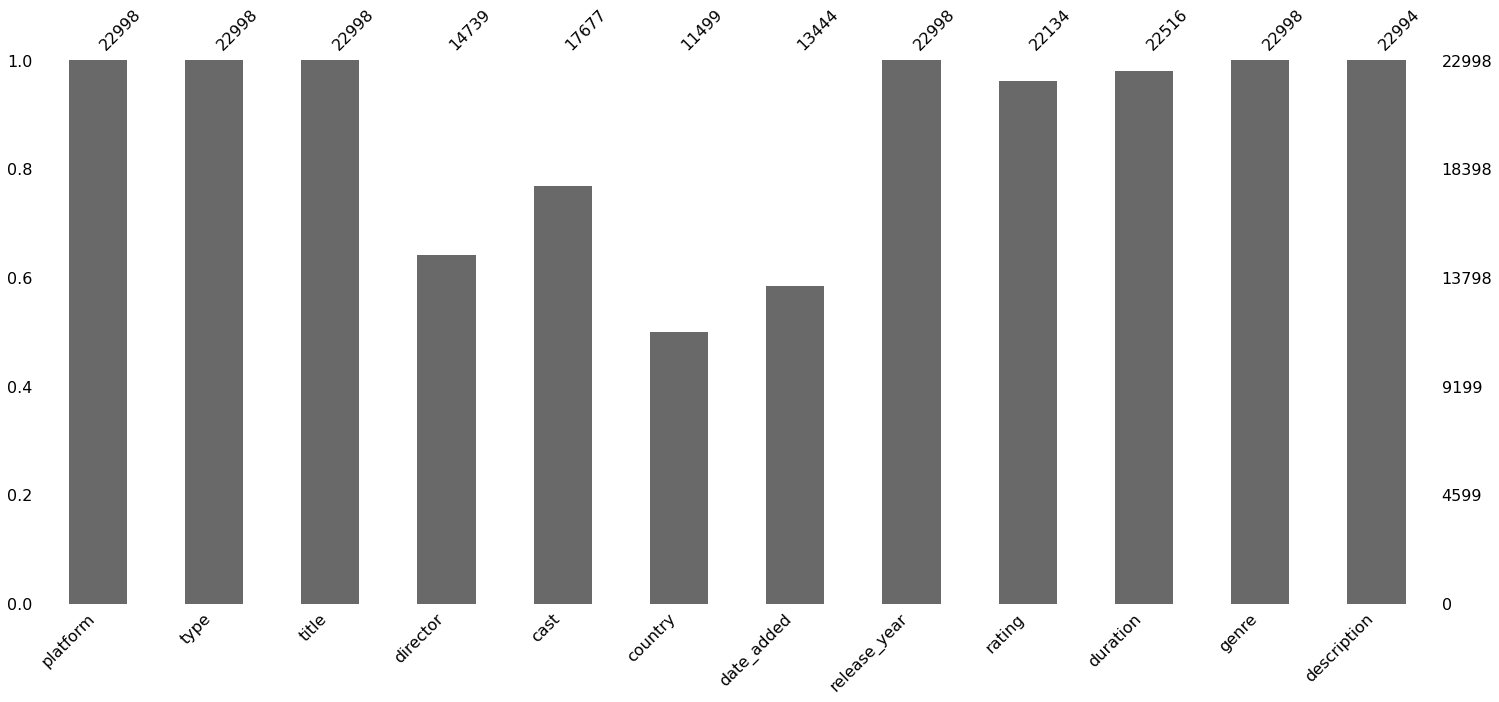

In [65]:
missno.bar(df)

<div class="alert alert-block alert-info">
    <b>Comment:</b> The <i>director</i>, <i>cast</i>, <i>country</i>, and <i>date_added</i> columns suffer the most in terms of missing values.
</div>

C:\Users\aooi5\anaconda3\lib\site-packages\missingno\missingno.py:61: UserWarning: Plotting a sparkline on an existing axis is not currently supported. To remove this warning, set sparkline=False.
  warnings.warn(


Text(0.5, 1.0, 'Netflix')

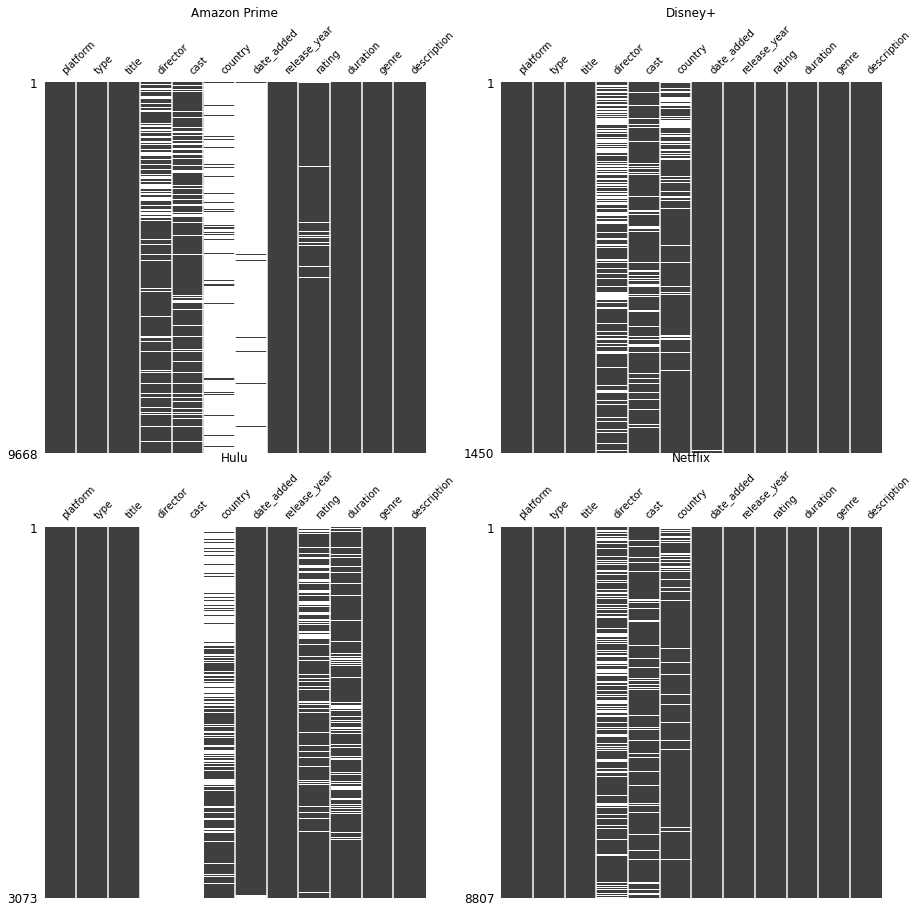

In [66]:
fig, axarr = plt.subplots(2,2)

fig.set_figheight(15)
fig.set_figwidth(15)

missno.matrix(df[df['platform']=='Amazon Prime'], ax=axarr[0][0], fontsize=10)
axarr[0][0].set_title("Amazon Prime")

missno.matrix(df[df['platform']=='Disney+'], ax=axarr[0][1], fontsize=10)
axarr[0][1].set_title("Disney+")

missno.matrix(df[df['platform']=='Hulu'], ax=axarr[1][0], fontsize=10)
axarr[1][0].set_title("Hulu")

missno.matrix(df[df['platform']=='Netflix'], ax=axarr[1][1], fontsize=10)
axarr[1][1].set_title("Netflix")

<div class="alert alert-block alert-info">
    <b>Comment:</b> By different platforms, the missing columns mentioned above are mainly from Amazon Prime and Hulu datasets. The data that is missing varies too, with Amazon Prime missing <i>country</i> and <i>date_added</i>, 
    while Hulu has almost the entirely of <i>director</i> and <i>cast</i> missing.
</div>

<AxesSubplot:>

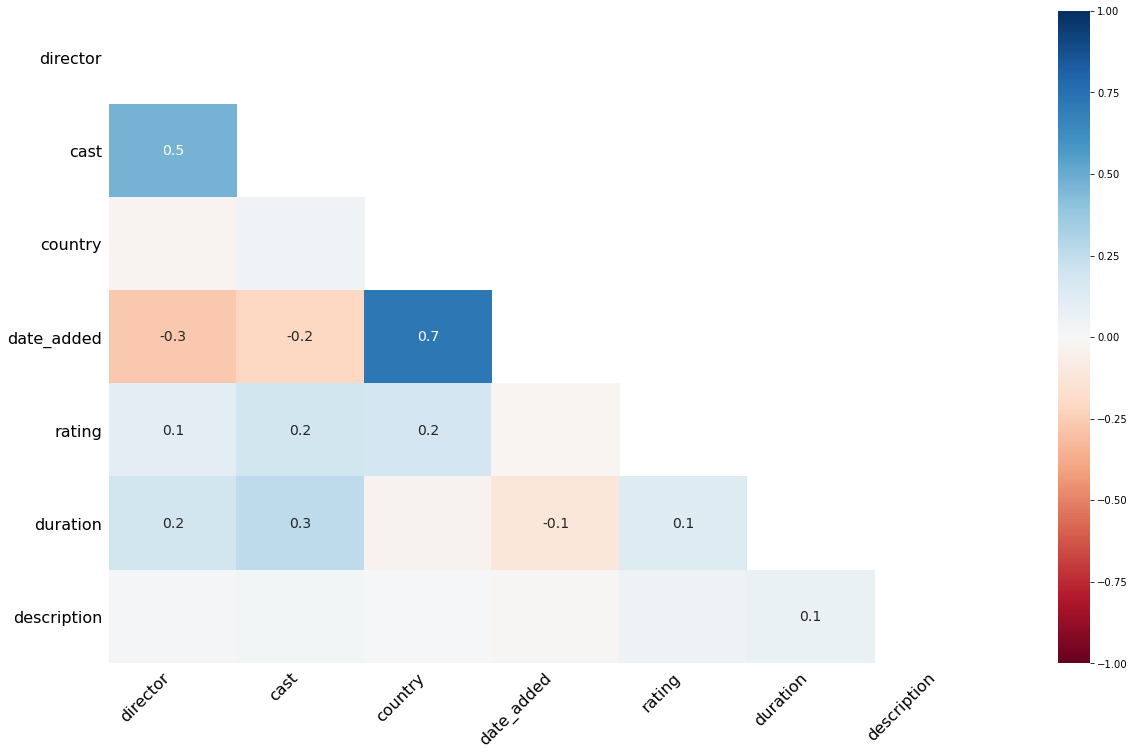

In [67]:
missno.heatmap(df)

<div class="alert alert-block alert-info">
    <b>Comment:</b> Heatmap did not provide any meaningful correlation in terms of missing values, although it seems that when date_added is present, country is also likely to be there.
</div>

##### Missing Directors and Cast data
As our targeted user can be particular about directors and cast when choosing a platform, we want to find out what these titles with these missing attributes are.

In [68]:
def missing_dir_cast_info(miss_type, df1):
    valid = {'director', 'cast'}
    if miss_type not in valid:
        raise ValueError('Must be either "director" or "cast"')
        
    # create a dataframe of missing directors
    df_null = df1[df1[miss_type].isnull()]

    # check if there are any patterns in type of shows or titles with missing directors
    mis_show = df_null['type'].unique().tolist()
    mis_title = set(df_null['title'].unique().tolist())

    # display results
    print(f'Missing {miss_type} summary: \n')
    print(f'The missing show types are: {mis_show}')
    print(f'There are {len(mis_title)} titles with missing {miss_type}')
    
    return mis_title

In [69]:
mis_director_title = missing_dir_cast_info('director', df)
print('\n' + ('-'*20) + '\n')
mis_cast_title = missing_dir_cast_info('cast', df)
print('\n' + ('-'*20) + '\n')
print(f'The total number of overlapped show titles between missing directors and casts are: {len(mis_director_title & mis_cast_title)}')

Missing director summary: 

The missing show types are: ['TV Show', 'Movie']
There are 7983 titles with missing director

--------------------

Missing cast summary: 

The missing show types are: ['TV Show', 'Movie']
There are 5281 titles with missing cast

--------------------

The total number of overlapped show titles between missing directors and casts are: 4087


<div class="alert alert-block alert-info">
    <b>Comment:</b> We note that there are significant overlaps in terms of show titles with missing directors or cast. As we have not much further information, we keep these missing values as Null for now.
</div>

#### 2. Duplicate titles analysis
- We suspect that there may be duplicate titles from the dataset
- This could stem from a title being hosted on multiple platforms, or a different in capitalization of letters in the titles


In [70]:
df = comb_platform('platform_files.txt')

##### Step 1: Unifying the title format
- As the tiles may have different capitalization and spacing, we unify their formating to all small caps and a single spacing between the words

In [71]:
# create a new column with uniform title formats (small caps, single spacing)
df['u_title'] = df['title'].apply(lambda x: ' '.join(x.split()).lower())

# move the u_title column next to original title column
df = movecol(df, cols_to_move=['u_title'], ref_col='title', place='After')

##### Step 2: Analysis of duplicated titles
- We check if the duplicated titles refers to the same show.

In [72]:
title_dup_bool = df[df['u_title'].duplicated(keep=False)].sort_values(['u_title'])

In [73]:
# Preliminary duplicates analysis:
tot_titles = len(df)
dup_titles = len(title_dup_bool)
dup_unique_titles = title_dup_bool['u_title'].nunique()

print('Duplicates analysis:')
print(f"The total number of titles in the datase (including duplicates) is: {tot_titles}")
print(f"The number of shows with duplicated titles (not withstanding type and release year) is: {dup_unique_titles}, which is {round(dup_unique_titles/tot_titles*100,1)}% of the dataset")
print(f"There is a total of {dup_titles} duplicated titles in the dataset, which is {round(dup_titles/tot_titles*100,1)}% of the dataset")

Duplicates analysis:
The total number of titles in the datase (including duplicates) is: 22998
The number of shows with duplicated titles (not withstanding type and release year) is: 898, which is 3.9% of the dataset
There is a total of 1856 duplicated titles in the dataset, which is 8.1% of the dataset


<div class="alert alert-block alert-info">
    <b>Comment:</b> From the summary above, we see that duplicate titles make up about 8% of the dataset. The may seem an issue preliminarily, but this summary only analyzes duplicated titles. We can have situations where show can have the exact same name but are completely different.
</div>

##### Step 3: Analysis of duplicated titles including other details (e.g. type of show, release years, directors etc)
- We extend our investigation to include other details of the shows to see if, even when the titles are the same, they are actually different
- Given the relatively large number of dataset, we took a sample of 40 duplicated shows to see how they behave

In [74]:
title_sample = title_dup_bool.head(40)

Text(0.5, 1.0, 'By show type')

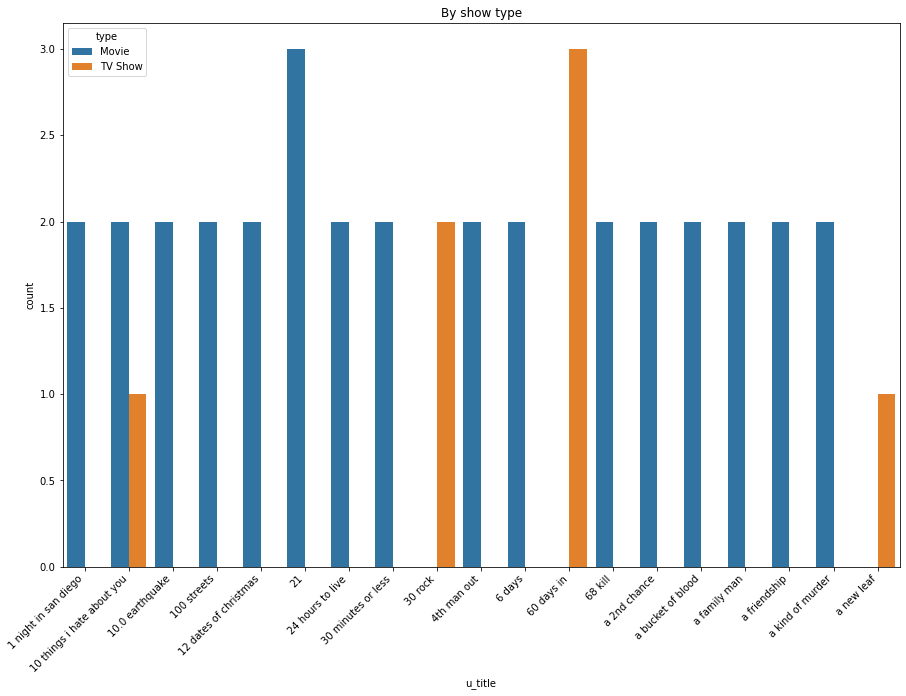

In [75]:
rcParams['figure.figsize'] = 15,10
chart = sns.countplot(x='u_title', hue='type', data=title_sample)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart.set_title('By show type')

Text(0.5, 1.0, 'By platform')

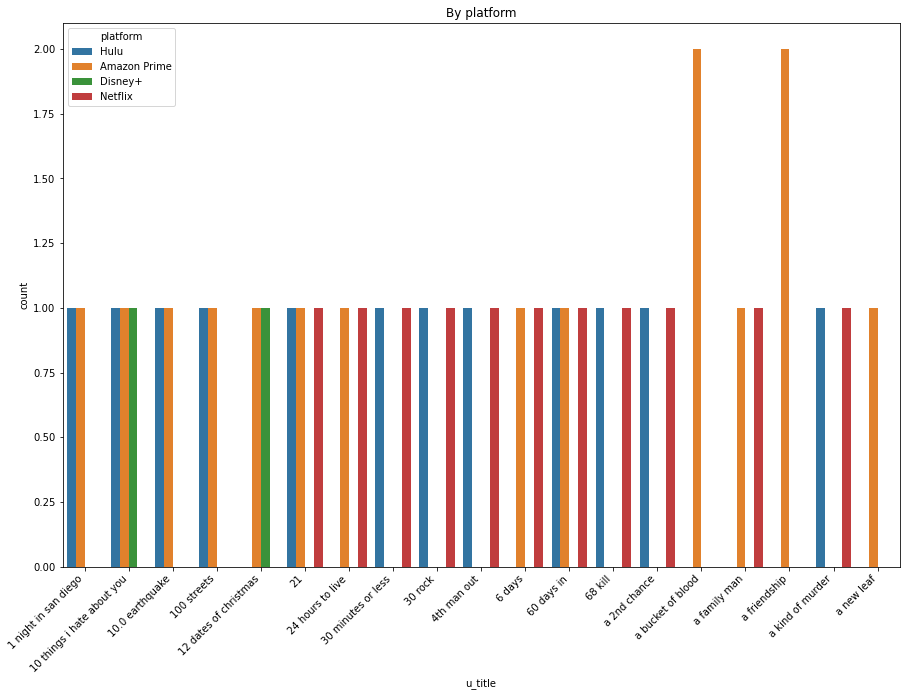

In [76]:
rcParams['figure.figsize'] = 15,10
chart = sns.countplot(x='u_title', hue='platform', data=title_sample)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart.set_title('By platform')

Text(0.5, 1.0, 'By release year')

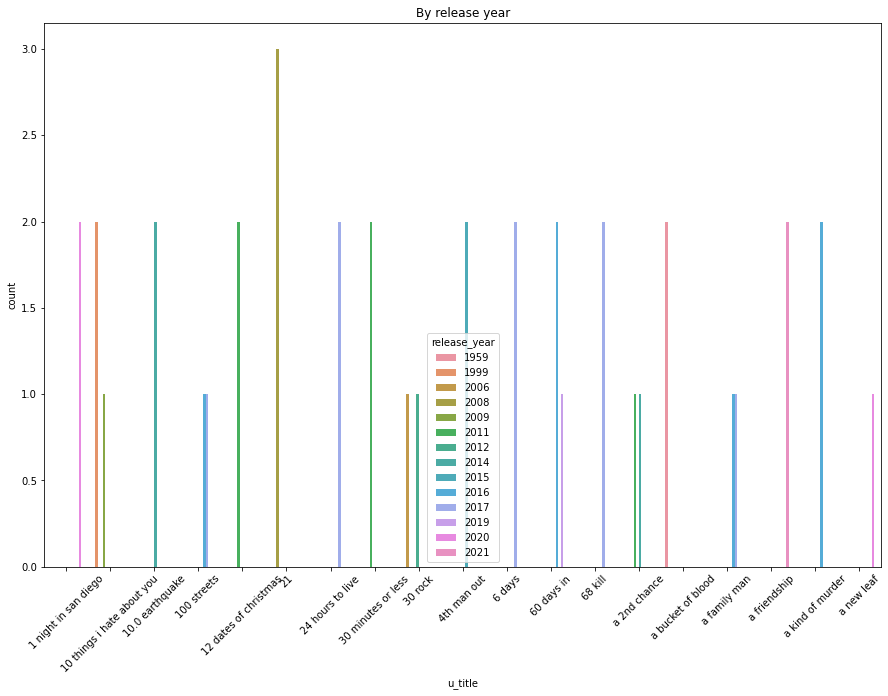

In [77]:
rcParams['figure.figsize'] = 15,10
chart = sns.countplot(x='u_title', hue='release_year', data=title_sample)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='center')
chart.set_title('By release year')

In [78]:
title_dup_bool.head(50).pivot_table(index=['u_title', 'type', 'platform', 'release_year'], aggfunc='count')

cast  country  \
u_title                    type    platform     release_year                  
1 night in san diego       Movie   Amazon Prime 2020             1        0   
                                   Hulu         2020             0        0   
10 things i hate about you Movie   Amazon Prime 1999             1        0   
                                   Disney+      1999             1        1   
                           TV Show Hulu         2009             0        1   
10.0 earthquake            Movie   Amazon Prime 2014             1        0   
                                   Hulu         2014             0        1   
100 streets                Movie   Amazon Prime 2017             1        0   
                                   Hulu         2016             0        1   
12 dates of christmas      Movie   Amazon Prime 2011             0        0   
                                   Disney+      2011             1        1   
21                         Movie   Amazon Prime 2008             1        0   
                                   Hulu         2008             0        0   
                                   Netflix      2008             1        1   
24 hours to live           Movie   Amazon Prime 2017             1        0   
                                   Netflix      2017             1        1   
30 minutes or less         Movie   Hulu         2011             0        0   
                                   Netflix      2011             1        1   
30 rock                    TV Show Hulu         2006             0        1   
                                   Netflix      2012             1        1   
4th man out                Movie   Hulu         2015             0        1   
                                   Netflix      2015             1        1   
6 days                     Movie   Amazon Prime 2017             1        0   
                                   Netflix      2017             1        1   
60 days in                 TV Show Amazon Prime 2016             0        0   
                                   Hulu         2016             0        1   
                                   Netflix      2019             0        1   
68 kill                    Movie   Hulu         2017             0        0   
                                   Netflix      2017             1        1   
a 2nd chance               Movie   Hulu         2014             0        0   
                                   Netflix      2011             1        1   
a bucket of blood          Movie   Amazon Prime 1959             2        0   
a family man               Movie   Amazon Prime 2017             1        1   
                                   Netflix      2016             1        1   
a friendship               Movie   Amazon Prime 2021             2        0   
a kind of murder           Movie   Hulu         2016             0        1   
                                   Netflix      2016             1        1   
a new leaf                 TV Show Amazon Prime 2020             1        0   
                                   Hulu         2019             0        1   
a night at the roxbury     Movie   Amazon Prime 1998             1        0   
                                   Netflix      1998             1        1   
a perfect ending           Movie   Hulu         2012             0        0   
                                   Netflix      2012             1        1   
a second chance            Movie   Amazon Prime 2019             1        0   
                                   Netflix      2015             1        1   
a wrinkle in time          Movie   Disney+      2018             1        1   
                                   Netflix      2018             1        1   
abhinetri                  Movie   Netflix      2016             1        1   

                                                              date_added  \
u_title                    type    

In [79]:
title_dup_bool.tail(50).pivot_table(index=['u_title', 'type', 'platform', 'release_year'], aggfunc='count')

cast  country  \
u_title                      type    platform     release_year                  
what lies beneath            Movie   Amazon Prime 2016             1        0   
                                     Netflix      2000             1        1   
what the shark?              Movie   Disney+      2020             1        0   
                                     Hulu         2020             0        0   
when sharks attack           TV Show Disney+      2013             1        1   
                                     Hulu         2018             0        0   
white fang                   Movie   Disney+      1991             1        1   
                                     Netflix      2018             1        1   
whitechapel                  TV Show Amazon Prime 2013             1        0   
                                     Hulu         2009             0        1   
whitney cummings: money shot Movie   Amazon Prime 2010             1        0   
                                     Netflix      2010             1        1   
whose streets?               Movie   Amazon Prime 2017             1        0   
                                     Netflix      2017             0        1   
why we fight                 Movie   Amazon Prime 2006             1        0   
                             TV Show Hulu         2017             0        0   
wind                         Movie   Amazon Prime 1992             1        0   
                                     Disney+      2019             1        1   
winx club                    TV Show Amazon Prime 2015             1        0   
                                     Netflix      2015             1        1   
wolves                       Movie   Amazon Prime 2014             1        0   
                                     Netflix      2016             1        1   
word of honor                TV Show Amazon Prime 2021             1        0   
                                     Netflix      2021             1        0   
world trade center           Movie   Amazon Prime 2006             1        1   
                                     Netflix      2006             1        1   
worth                        Movie   Amazon Prime 2021             1        0   
                                     Netflix      2021             1        0   
wwii in hd                   TV Show Amazon Prime 2009             1        0   
                                     Netflix      2009             1        1   
xx                           Movie   Hulu         2017             0        1   
                                     Netflix      2017             1        1   
young adult                  Movie   Hulu         2011             0        1   
                                     Netflix      2011             1        1   
your lie in april            TV Show Hulu         2014             0        1   
                                     Netflix      2014             1        1   
yu-gi-oh!                    TV Show Hulu         2001             0        1   
                                     Netflix      2005             1        1   
yu-gi-oh! 5d's               TV Show Amazon Prime 2011             1        0   
                                     Hulu         2008             0        1   
yu-gi-oh! arc-v              TV Show Amazon Prime 2018             1        0   
                                     Hulu         2016             0        0   
                                     Netflix      2015             1        1   
yu-gi-oh! zexal              TV Show Amazon Prime 2015             1        0   
                                     Hulu         2011             0        1   
zaki chan                    Movie   Amazon Prime 2005             1        1   
                                     Netflix      2005             1        1   
zapped                       Movie   Disney+      2014             1        1   
              

<div class="alert alert-block alert-info">
    <b>Comment 1:</b> From the various analyses above, we see that duplicated titles can refer to different shows altogether, and, based on the our dataset, we can filter down a uniqueness of a show by it's title, release date, and type (movie or tv-show). Although this is not fool-proof, we will check how many duplicated shows is in the dataset by filtering through this criteria.
</div>
<div class="alert alert-block alert-info">
    <b>Comment 2:</b> In addition, we see that show names may be duplicated as they can be hosted on different platforms.
</div>

##### Step 4: Analysis of duplicated titles
- We check for duplicated titles, and here we define a title as unique if they have the sames title, release year, type of show, and duration.

In [80]:
# check for duplicated titles across release years, types, and duration of the show
title_dup = df[df.duplicated(subset=['u_title', 'release_year', 'type', 'duration'], keep=False)].sort_values(['u_title'])

In [81]:
# Preliminary duplicates analysis:
tot_titles = len(df)
dup_titles = len(title_dup)
dup_unique_titles = title_dup['u_title'].nunique()

print('Duplicates analysis:')
print(f"The total number of titles in the datase (including duplicates) is: {tot_titles}")
print(f"The number of shows with duplicated titles is: {dup_unique_titles}, which is {round(dup_unique_titles/tot_titles*100,1)}% of the dataset")

Duplicates analysis:
The total number of titles in the datase (including duplicates) is: 22998
The number of shows with duplicated titles is: 273, which is 1.2% of the dataset


<div class="alert alert-block alert-info">
    <b>Comment:</b> Finding duplicates with the same 'u_title', 'release_year', 'type', 'duration' (a more stringent criteria) yields only about 273 duplicate titles or about 1% of the total dataset. For the next step, we will work on unifiying the features of this dataset (namely directors, cast, and genre).
</div>

## Unify features of duplicated titles
- We will unify the directors, cast, country, and genre with the same title
- In this step, we assume that features with the longest content (e.g. the largest number of directors) holds the most information
- Hence in unifying the features, we choose the one with the longest content and apply that to all the duplicated titles

##### Unifying title features
We use the function `unify_feature` below to unify the following features of a title (for consistency and fair comparison between platforms)

In [82]:
# process raw dataframe (unify title and find duplicates in the dataframe)
def preproc_dup_df(df):

    # create a new column with uniform title formats (small caps, single spacing)
    df['u_title'] = df['title'].apply(lambda x: ' '.join(x.split()).lower())
    
    # move the u_title column next to original title column
    df = movecol(df, cols_to_move=['u_title'], ref_col='title', place='After')
    
    # label indicating duplicated titles (across release years, types, and duration of the show)
    df_dup = df[df.duplicated(subset=['u_title', 'release_year', 'type', 'duration'], keep=False)] # create another dataframe
    
    return df, df_dup


# create a dictionary to store the longest feature data
# we assume that df passed to the function is a dataframe that only contains duplicated titles
def make_feature_dict(df_dup, filter_by, feature):
    uf_dict = {}
    
    # extract only the required columns
    # and drop titles with null values (i.e. if all titles do not have any feature info, it should 
    # not be in the dictionary at all)
    df_feat = df_dup[[filter_by, feature]].copy()
    df_feat = df_feat.dropna()
    
    #create a list consisting only of the titles
    title_list = df_feat['u_title'].unique().tolist()
    
    # create a dictionary to consist only of the longest item in the list of features
    for i in title_list:
        feat_list = df_feat[df_feat[filter_by]==i][feature].tolist()
        uf_dict[i] = max(feat_list, key=len)
    
    return uf_dict


# function creates a new column of unified features
# takes in as input a pre-processed dataframe (includes'u_title','is_duplicate' columns)
def unify_feature(df_proc, df_dup, filter_by, feature):
    
    # create a dictionary of unique titles and corresponding features with most info
    uf_dict = make_feature_dict(df_dup, filter_by, feature)
    
    df_proc[feature] = df.apply(lambda x: replace_feat(x[filter_by], x[feature], uf_dict), axis=1)
    
    return df_proc


# lambda function called within the 'unify_feature' function above
def replace_feat(a, b, dict):
    if a in dict:
        return dict[a]
    else:
        return b



- Using the codes above, we can create a dataframe where several features are unified:
    - director
    - cast
    - country
    - genre
    - description

In [83]:
# create a raw dataframe
df = comb_platform('platform_files.txt')

# pre-process the dataframe
df, df_dup = preproc_dup_df(df)

# create a list of features to unify:
features_list = ['director', 'cast', 'country', 'genre', 'description']
filter_by = 'u_title'

for f in features_list:
    df = unify_feature(df, df_dup, filter_by, f)

# removing redundant columns
df = df.drop(['u_title'], axis=1)

In [84]:
# test
(df[df['title']=='The Untamed']['cast'].tolist())

['Sean Xiao, Wang Yibo, Zoey Meng, Xuan Lu, Yu Bin, Wang Zhuocheng, Liu Haikuan, Zhu Zanjin, Wang Haoxuan, Ji Li',
 'Sean Xiao, Wang Yibo, Zoey Meng, Xuan Lu, Yu Bin, Wang Zhuocheng, Liu Haikuan, Zhu Zanjin, Wang Haoxuan, Ji Li']

## Clean *'rating'* and *'duration'* columns
- There are a number of values in the **"rating"** (maturity rating) column indicating the duration of the title e.g. (2 Seasons, 79 Min). This should logically should be in the 'duration' column
- Further investigation shows that these values are indeed misplaced and should be in the the **'duration'** column, where the values are Null
- See results below:

In [85]:
df.rating.unique()

array([nan, '13+', 'ALL', '18+', 'R', 'TV-Y', 'TV-Y7', 'NR', '16+',
       'TV-PG', '7+', 'TV-14', 'TV-NR', 'TV-G', 'PG-13', 'TV-MA', 'G',
       'PG', 'NC-17', 'UNRATED', '16', 'AGES_16_', 'AGES_18_', 'ALL_AGES',
       'NOT_RATE', 'TV-Y7-FV', 'NOT RATED', '2 Seasons', '93 min',
       '4 Seasons', '136 min', '91 min', '85 min', '98 min', '89 min',
       '94 min', '86 min', '3 Seasons', '121 min', '88 min', '101 min',
       '1 Season', '83 min', '100 min', '95 min', '92 min', '96 min',
       '109 min', '99 min', '75 min', '87 min', '67 min', '104 min',
       '107 min', '84 min', '103 min', '105 min', '119 min', '114 min',
       '82 min', '90 min', '130 min', '110 min', '80 min', '6 Seasons',
       '97 min', '111 min', '81 min', '49 min', '45 min', '41 min',
       '73 min', '40 min', '36 min', '39 min', '34 min', '47 min',
       '65 min', '37 min', '78 min', '102 min', '129 min', '115 min',
       '112 min', '61 min', '106 min', '76 min', '77 min', '79 min',
       '157 min', '

<div class="alert alert-block alert-info">
    <b>Comment:</b> The 'rating' column has data on duration of the titles
</div>

In [86]:
df_test = df.loc[df['duration'].isnull() & ~(df['rating'].isnull())]

In [87]:
df_test.rating.unique()

array(['TV-MA', '2 Seasons', 'TV-PG', '93 min', 'TV-14', '4 Seasons',
       '136 min', 'TV-G', '91 min', '85 min', '98 min', '89 min',
       '94 min', '86 min', '3 Seasons', '121 min', '88 min', '101 min',
       '1 Season', '83 min', '100 min', '95 min', '92 min', '96 min',
       '109 min', '99 min', '75 min', '87 min', '67 min', '104 min',
       '107 min', '84 min', '103 min', '105 min', '119 min', '114 min',
       '82 min', '90 min', '130 min', '110 min', '80 min', '6 Seasons',
       '97 min', '111 min', '81 min', '49 min', '45 min', '41 min',
       '73 min', '40 min', '36 min', '39 min', '34 min', '47 min',
       '65 min', '37 min', '78 min', '102 min', '129 min', '115 min',
       '112 min', '61 min', '106 min', '76 min', '77 min', '79 min',
       '157 min', '28 min', '64 min', '7 min', '5 min', '6 min',
       '127 min', '142 min', '108 min', '57 min', '118 min', '116 min',
       '12 Seasons', '71 min', '74 min', '66 min'], dtype=object)

<div class="alert alert-block alert-info">
    <b>Comment:</b> The time duration data on the 'rating' column corresponds to null values in the 'duration' column
</div>

### Copy misplaced duration values from *'ratings'*  to *'duration'* column
- The function `correct_ratings_to_duration` copies misplaced duration values from **'ratings'** to **'duration'** column

In [88]:
def correct_ratings_to_duration(df):
    
    # swap misplaced duration values from 'ratings' to 'duration' column
    df.loc[(df['duration'].isnull() & df['rating'].astype(str).str.contains('min|Season')), ['rating', 'duration']] = \
       df.loc[(df['duration'].isnull() & df['rating'].astype(str).str.contains('min|Season')), ['duration', 'rating']].values
    
    return df 

### Split *'duration'* data into numerical and units
- **'duration'** has both the numerical data as well as the unit (seasons, minutes)
- We will split this into two columns (create a new column **'durating_type'** to record the duration type)
- The function `split_duration` splits 'duration' into numerical data as well as units

In [89]:
def split_duration(df):
    
    # create a new column 'duration_type' to record the unit of the duration
    # and leave only the quantity in the 'duration' column
    df[['duration','duration_type']] = df.duration.str.split(expand=True)
    
    # in 'duration_type' column, unify 'Seasons' and 'Season' as the same unit of measure
    df.duration_type.replace({'Seasons':'Season'},inplace=True) 
    
    # move 'duration_type' column next to 'duration'
    df = movecol(df, cols_to_move=['duration_type'], ref_col='duration', place='After')
    
    return df

In [90]:
df = correct_ratings_to_duration(df)

In [91]:
df = split_duration(df)

In [92]:
# function returns a dictionary of age ratings
def age_bucket_dict(age_bucket_file):
    f = open(age_bucket_file, 'r+')
    rating_age_dict = {}
    
    for line in f.readlines():
        r = [x.strip() for x in line.split(',')]
        rating_age_dict[r[0]] = r[1]
    
    return rating_age_dict

# create a new column 'targeted_age' in the dataframe
# and bucket the show ratings according to age brackets (defined in the age_bucket_file)
def create_rating_age_bucket(df, age_bucket_file):
    
    rating_age_dict = age_bucket_dict(age_bucket_file)
    
    df['targeted_age'] = df['rating'].replace(rating_age_dict)
    
    df = movecol(df, cols_to_move=['targeted_age'], ref_col='rating', place='After')
    
    return df

In [93]:
age_bucket_file = 'rating_age_bucket.csv'
df = create_rating_age_bucket(df, age_bucket_file)

## Genre Cleanup (Analysis)
- An analysis below shows that platforms classify genres differently. In addition, a show can be classified with multiple genres, and the naming of these genres are not standardized across different platforms.

In [94]:
# here we list out all the possible genres in our dataset

from itertools import chain
import seaborn as sns

df = comb_platform('platform_files.txt')


# create a dataframe only consisting of 'platform' and 'genre' columns
df1 = df[['platform', 'genre']].copy()


# as the 'genre' column can have more than one genre, we manipulate the dataframe and split the genres out
# so that each row has a platform and a genre
df1['genre'] = df1['genre'].apply(lambda x: x.split(','))

df1 = pd.DataFrame({
    'platform' : df1.platform.repeat(df1.genre.str.len()),
    'genre' : list(chain.from_iterable(df1.genre))
})

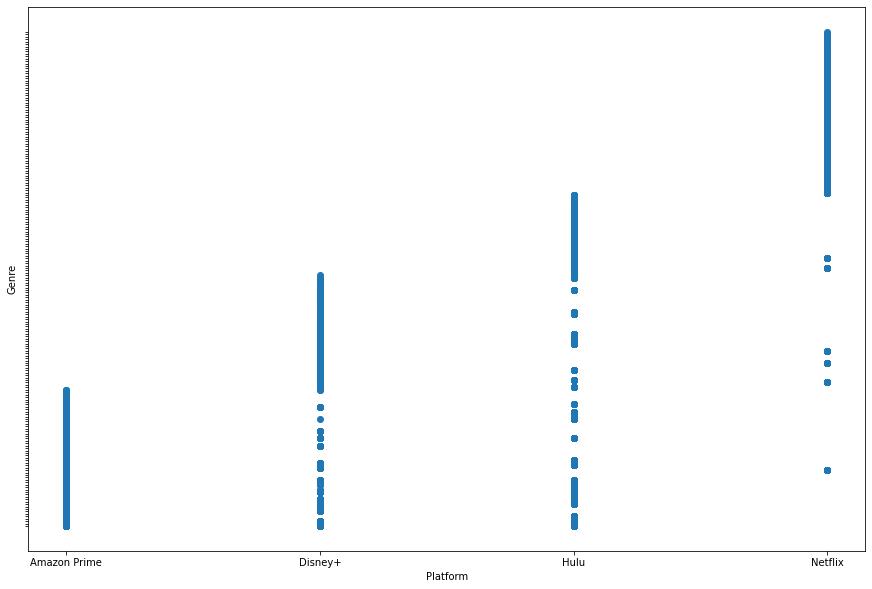

In [95]:
import matplotlib.pyplot as plot

# create Figure and Axes instances
fig, ax = plt.subplots(1)

x = df1['platform']
y = df1['genre']

# make scatter plot
ax.scatter(x, y)
ax.set_xlabel('Platform')
ax.set_ylabel('Genre')

# remove genre label as there are more than 200 genres
ax.set_yticklabels([])

plt.show()

In [101]:
# we summarize in tabular form how the platforms classify the genres

pd.set_option('display.max_rows', None)

df1.drop_duplicates(subset=['platform', 'genre'], keep='first', inplace=True)
print('-' * 80)
print(f'There are {len(df1.genre.unique())} genres in our dataset')
print('-' * 80)
print('')
print('An example of how the Anime genre is represented by different platforms below:')
print('-' * 80)
# display(df1.groupby(['genre', 'platform']).first())
df1.groupby(['genre', 'platform']).first().head(10)

# reset display options
# pd.reset_option('all')

--------------------------------------------------------------------------------
There are 204 genres in our dataset
--------------------------------------------------------------------------------

An example of how the Anime genre is represented by different platforms below:
--------------------------------------------------------------------------------


Empty DataFrame
Columns: []
Index: [( Adult Animation, Hulu), ( Adventure, Amazon Prime), ( Adventure, Hulu), ( Animals & Nature, Disney+), ( Animation, Amazon Prime), ( Animation, Disney+), ( Anime, Amazon Prime), ( Anime, Disney+), ( Anime, Hulu), ( Anime Features, Netflix)]

<div class="alert alert-block alert-info">
    <b>Comment:</b> Our dataset has a large number of unique genre names (204 in total). The scatterplot shows that the genre names are distributed differently across platforms. While this may be because platforms may focus on certain genres compared to others, a granular examination of listing of genres across platforms shows that different platforms name genres differently (e.g. 'Comedies' vs 'Comedy', 'Horror' vs ' Horror Movies', etc).
</div>

## Genre Cleanup (Process)
- Based on the analysis above, we clean up the genre with a two-step process:
    1. Unify genres by defining major genres, and combine sub-genres into major genres. To do that, we defined our own major genres to encompass various genre names in our dataset.
    2. Create a 'one-hot' encoding of these major genres

In [94]:
# create a dictionary consisting of major genres and the corresponding sub-genres
# this dictionary is based on our own definition and classification, 
# which is specified within a text file ('genre_cleaning.txt')
def get_genre_dict(genre_filepath):
    f = open(genre_filepath, "r+")
    genre_dict = {}
    
    for line in f.readlines():
        is_detailed_genre = (line[0] == "\t")
        line = " ".join(line.strip().lower().split())
        
        if is_detailed_genre:
            genre_dict[current_genre].append(line)
        else:
            current_genre = line
            genre_dict[current_genre] = []

    return genre_dict


# function checks if a sub-genre belongs to a major genre
def is_in_major_genre(comma_separated_list, major_genre, genre_dict):
    
    listed_strip = [" ".join(c.split()) for c in comma_separated_list.split(",")]
    inner = set(listed_strip) & set(genre_dict[major_genre])
    
    return len(inner) > 0


# function creates one-hot columns for major genres
# and populates it with 1, if the show is within the major genre. Otherwise will populate with 0

def create_major_genres(df, col_header='genre', genre_file='genre_cleaning.txt', prefix_1hot='_'):
    
    genre_dict = get_genre_dict(genre_file)
    
    tmp = "genre_tmp"
    df[tmp] = df[col_header].apply(lambda x: " ".join(x.split()).lower())
    
    col_1hot_list = []

    for genre in genre_dict.keys():
        col_1hot = f"{prefix_1hot}{genre.title()}"
        col_1hot_list.append(col_1hot)
        df[col_1hot] = df[tmp].apply(lambda x: int(is_in_major_genre(x, genre, genre_dict)))

    df.drop(columns=tmp, inplace=True)
    
    return df

In [95]:
df = comb_platform('platform_files.txt')

In [96]:
df2 = create_major_genres(df, col_header='genre', genre_file='genre_cleaning.txt', prefix_1hot='_')

## Process *'director'* column
- Overall, the 'director' data is more than 50% complete, and is missing completely in the Hulu dataset. Despite this, We can still derive insights from this dataset.

In [99]:
df_dir = comb_platform('platform_files.txt')

<div class="alert alert-block alert-info">
    <b>Comment:</b> We see that director and cast data are mainly missing from the Hulu dataset, but we can still have meaningful data from the other platforms
</div>

C:\Users\aooi5\anaconda3\lib\site-packages\missingno\missingno.py:61: UserWarning: Plotting a sparkline on an existing axis is not currently supported. To remove this warning, set sparkline=False.
  warnings.warn(


Text(0.5, 1.0, 'Netflix')

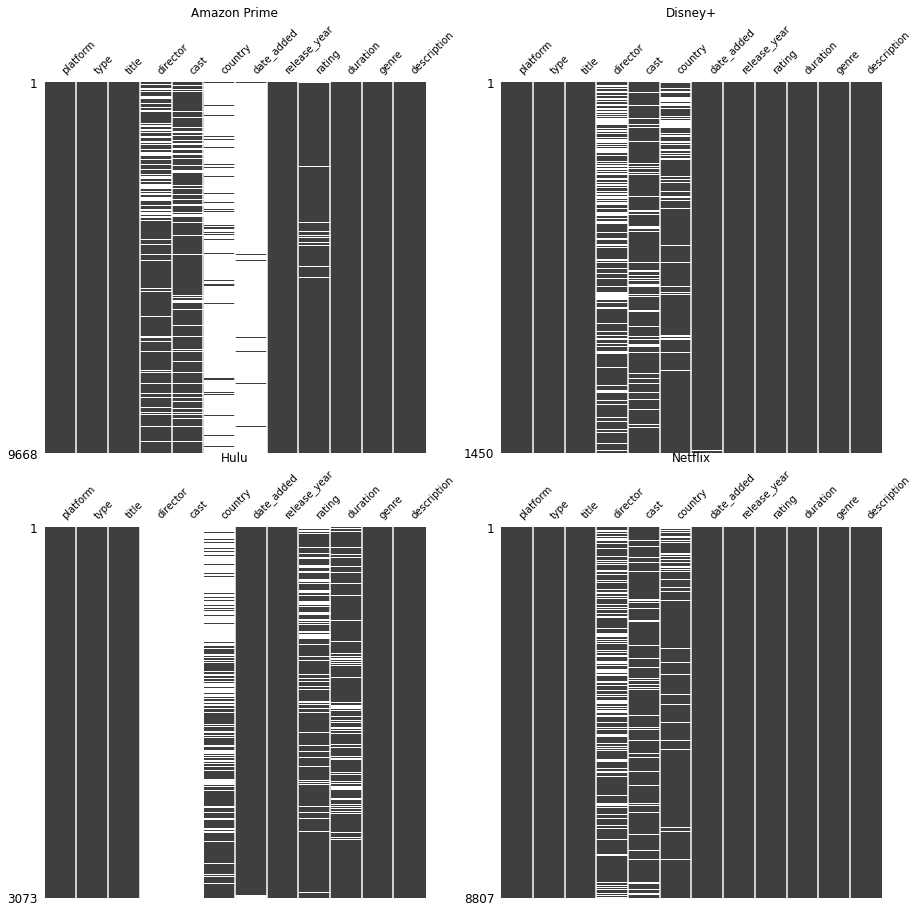

In [100]:
fig, axarr = plt.subplots(2,2)

fig.set_figheight(15)
fig.set_figwidth(15)

missno.matrix(df_dir[df_dir['platform']=='Amazon Prime'], ax=axarr[0][0], fontsize=10)
axarr[0][0].set_title("Amazon Prime")

missno.matrix(df_dir[df_dir['platform']=='Disney+'], ax=axarr[0][1], fontsize=10)
axarr[0][1].set_title("Disney+")

missno.matrix(df_dir[df_dir['platform']=='Hulu'], ax=axarr[1][0], fontsize=10)
axarr[1][0].set_title("Hulu")

missno.matrix(df_dir[df_dir['platform']=='Netflix'], ax=axarr[1][1], fontsize=10)
axarr[1][1].set_title("Netflix")

### Distribution of number of directors in the dataset

- There may be more than one director for a show (separated by commas in the 'director' columns
- We find most shows overwhelmingly have only one director (13,000+ shows), followed by two directors (1000+) which is an order of magnitude lower in quantity than movies with one director
- We assume here that in the 'director' column, the directors are ordered by importance. Hence, we create a new column 'main_director' to capture that information

In [101]:
# we create a function to count the distribution of directors and cast

def show_count(feat_count, datafile='platform_files.txt'):
    
    valid = {'director', 'cast'}
    if feat_count not in valid:
        raise ValueError('Must be either "director" or "cast"')

    df = comb_platform(datafile)

    # Create a dummy column to count the number of directors in each show
    df1 = df[[feat_count]].copy().dropna()
    df1[feat_count] = df1[feat_count].str.split(',')
    df1['n_count'] = df1[feat_count].str.len()

    print(f'A summary of the distribution of number of {feat_count}s for shows:')

    ax = sns.countplot(x='n_count', data=df1)

    for p in ax.patches:
       ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.2, p.get_height()+10))

    ax.set_xlabel(f'Number of {feat_count} in shows', fontsize=10)
    ax.set_ylabel('Count', fontsize=10)

    plt.show()

A summary of the distribution of number of directors for shows:


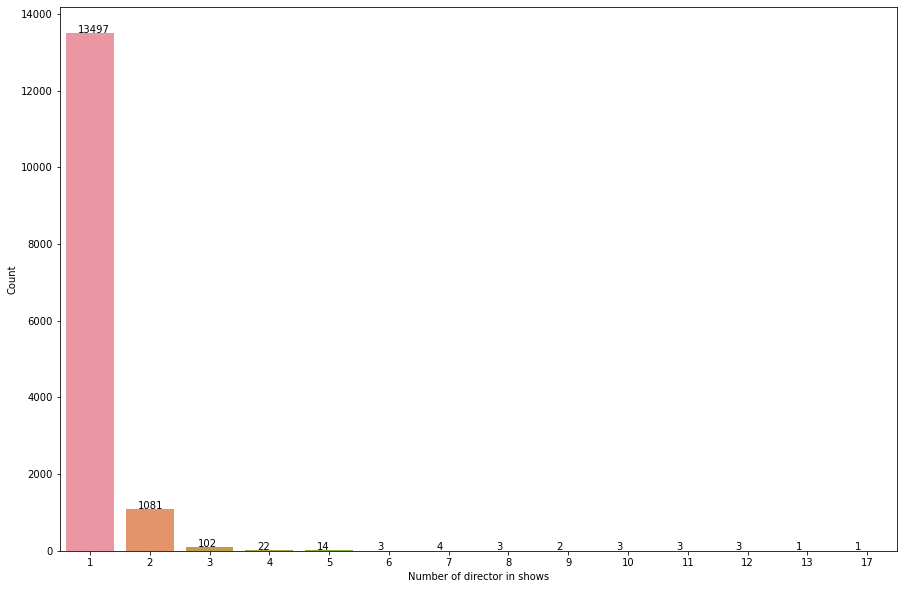

In [102]:
show_count('director')

### Summarize directors - create a new *'main_director'* column
- The function `create_col_major_director` creates a new column outlining the main director of the show

In [103]:
def create_col_main_director(df):

    # Step 1, we create a new column to house only the main director
    df['main_director'] = df['director'].apply(lambda x : x.split(',')[0] if not pd.isnull(x) else np.nan)
    
    # Step 2, we re-arrange the layout of the columns
    df = movecol(df, cols_to_move=['main_director'], ref_col='director', place='After')
    
    return df

In [104]:
df = comb_platform('platform_files.txt')

In [105]:
df = create_col_main_director(df)

A summary of the distribution of number of casts for shows:


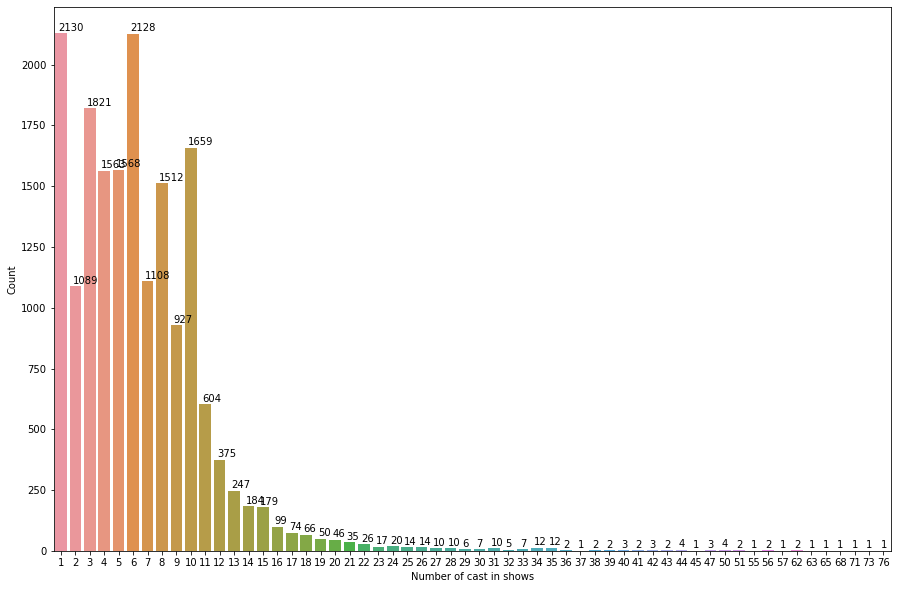

In [107]:
show_count('cast')

### Summarize cast - create new columns to capture important cast data
- The function `create_cols_main_cast` creates new columns summarizing the cast of the show
- 'n_cast': outline the number of cast
- 'main_cast_1': the first cast in the list of casts
- 'main_cast_2': the second cast
- etc and extract up to 6 casts, as that is the average number of casts in the dataset

In [108]:
def create_cols_main_cast(df, n=2, set_n=False):
    
    # Step 1: create a column 'n_cast' to count the number of cast
    # note this returns a null (NaN) value if the 'cast' column is a null (NaN)
    df['n_cast'] = df['cast'].str.split(',')
    df['n_cast'] = df['n_cast'].str.len()
    
    # step 2: determine the number of main cast columns to create:
    #
    # parameter 'set_n' lets user specify the number of cast columns to create:
    #    if it is set to False, the function automatically create the x columns
    #        where x is the average number of casts in the dataset
    #    otherwise, 
    #        number of columns will be set to n, which is specified by the user
    if not set_n:
        n = int(df['n_cast'].mean()) 
    
    # Step 3: Dynamically create new columns
    for i in range(n):
        col_name = 'main_cast_' + str(i+1)
        df[col_name] = df['cast'].apply(lambda x : x.split(',')[i] if (not pd.isnull(x) and len(x.split(',')) >= (i+1))  else np.nan)
  
    
    # Step 3, we re-arrange the layout of the columns (starting from 'n_cast' column)
    col_list = list(df.columns)
    start_col = col_list.index('n_cast')
    cols_to_move = col_list[start_col:]
    
    df = movecol(df, cols_to_move, ref_col='cast', place='After')
    
    return df

In [109]:
df = comb_platform('platform_files.txt')

In [110]:
df = create_cols_main_cast(df, n=3, set_n=True)

<div class="alert alert-block alert-info">
<b>Comment:</b> We have created functions to filter out important directors and cast members, and present these data in separate columns. This will make our show analysis easier.
</div>

## Incorporate IMDb critic ratings to the titles
- We supplement our combined dataset with critic ratings (IMDb) using a new dataset.
- This dataset includes IMDb and Rotten Tomatoes ratings of shows hosted on the four streaming platforms above.

*Data Source:*
- https://www.kaggle.com/code/ruchi798/movies-data-collection-eda-using-tableau/data

### Merge critic ratings to the existing dataframe
- The function `merge_critic_ratings` incorporates the critic ratings (both IMDb and Rotten Tomatoes)
- Merging is done based on commonality in the two dataframes across: (1) the show title (converted to all smallcaps and single spacing between words), (2) the release year. We include also the release year, as there are different shows with the same titles.

In [112]:
# function merges IMDb critic ratings to the existing dataset of platform shows
# df_comb is the dataframe of combined platforms

def merge_critic_ratings(rating_file, df_comb):
    df_ratings = pd.read_csv(rating_file)
    
    # created a 'new_title' column (lower caps, only one space) for both dataframes
    df_comb['new_title'] = df_comb['title'].apply(lambda x: " ".join(x.split()).lower())
    df_ratings['new_title'] = df_ratings['Title'].apply(lambda x: " ".join(x.split()).lower())
    
    # incorporate the critic ratings using the merge function
    df_new = pd.merge(df_comb, df_ratings[['new_title', 'Year','IMDb', 'Rotten Tomatoes', ]], how="left", left_on=['new_title', 'release_year'], right_on=['new_title', 'Year'])
    
    # remove redundant columns
    df_new = df_new.drop(['new_title', 'Year'], axis=1)
    
    return df_new

In [113]:
# test
df_comb = comb_platform('platform_files.txt')
rating_file = 'ratings_MoviesRatings.csv'

df_comb = merge_critic_ratings(rating_file, df_comb)

In [114]:
df_comb.notnull().sum()

platform           22998
type               22998
title              22998
director           14739
cast               17677
country            11499
date_added         13444
release_year       22998
rating             22134
duration           22516
genre              22998
description        22994
IMDb                4549
Rotten Tomatoes     2208
dtype: int64

 <div class="alert alert-block alert-info">
<b>Comment:</b> Based on the methodology above, the are only about 4,500 titles with IMDb ratings, which is only about 20% of all titles in our combined dataset. This could be that our ratings dataset only cover movies, and there may be inconsistencies between title names and release dates.
</div>

# Visualization

### Generate processed and cleaned datafram
- Using the functions and analysis we performed above, we generate clean and enriched dataframe

In [115]:
# Generate dataframe from cleanups described previously

pd.set_option('display.max_columns', None)

# 1. Create a basic dataframe from streaming platform data
df = comb_platform('platform_files.txt')


# 2. Unify features of shows (so that a show will have a unified director, cast, country, genre, and description)
df, df_dup = preproc_dup_df(df)

features_list = ['director', 'cast', 'country', 'genre', 'description']
filter_by = 'u_title'

for f in features_list:
    df = unify_feature(df, df_dup, filter_by, f)

df = df.drop(['u_title'], axis=1)


# 3. Clean up rating and duration columns
df = correct_ratings_to_duration(df)
df = split_duration(df)


# 4. Group age ratings
age_bucket_file = 'rating_age_bucket.csv'
df = create_rating_age_bucket(df, age_bucket_file)


# 5. Group genre and create one-hot encoding of major genres
df = create_major_genres(df, col_header='genre', genre_file='genre_cleaning.txt', prefix_1hot='_')


# 6. summarize directors by creating a new 'main_director' column
df = create_col_main_director(df)


# 7. summarize cast by creating a new 'main_cast' columns
df = create_cols_main_cast(df, n=2, set_n=True)


# 8. merge critic ratings
rating_file = 'ratings_MoviesRatings.csv'
df = merge_critic_ratings(rating_file, df)


## Viz: No. of platform-hosted shows

In [118]:
df_show_type = df[['platform', 'type']]

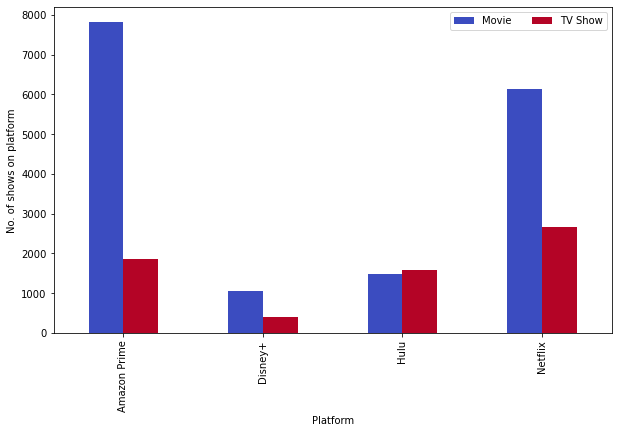

In [119]:
cross_tab_shows = pd.crosstab(index=df_show_type['platform'], columns=df_show_type['type'])

cross_tab_shows.plot(kind='bar', stacked=False, colormap='coolwarm', figsize=(10,6))

plt.legend(loc='best', ncol=6)
plt.xlabel('Platform')
plt.ylabel('No. of shows on platform')
plt.show()

<div class="alert alert-block alert-info">
<b>Comment:</b> Amazon Prime and Netflix has the most number of shows, and their titles focus more on movies
</div>

## Viz: Proportion of shows by type on each respective platform

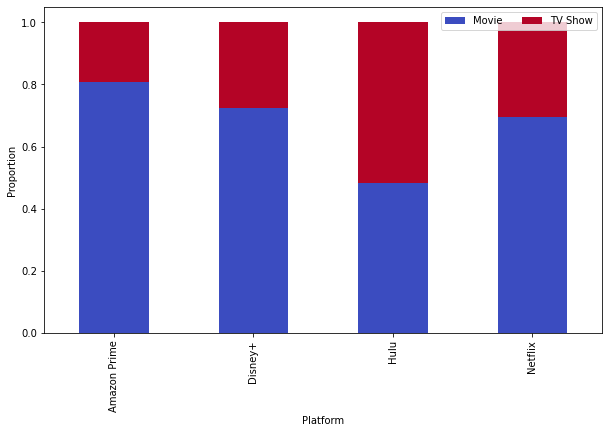

In [120]:
cross_tab_show_type = pd.crosstab(index=df_show_type['platform'], columns=df_show_type['type'], normalize='index')

cross_tab_show_type.plot(kind='bar', stacked=True, colormap='coolwarm', figsize=(10,6))

plt.legend(loc='best', ncol=6)
plt.xlabel('Platform')
plt.ylabel('Proportion')
plt.show()

<div class="alert alert-block alert-info">
<b>Comment:</b> In terms of proportions, Hulu has the highest proportion of TV-show offerings of all the platforms
</div>

## Viz: IMDb Ratings Analysis

<AxesSubplot:xlabel='platform', ylabel='count'>

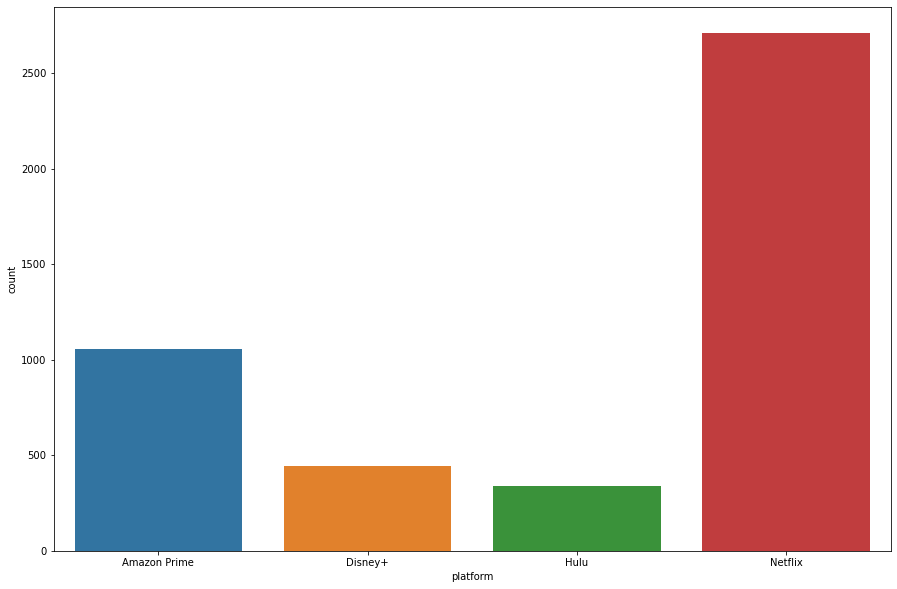

In [121]:
df_imdb_plot = df[['platform', 'IMDb']]
df_imdb_plot = df_imdb_plot.dropna()

sns.countplot(data=df_imdb_plot, x='platform')

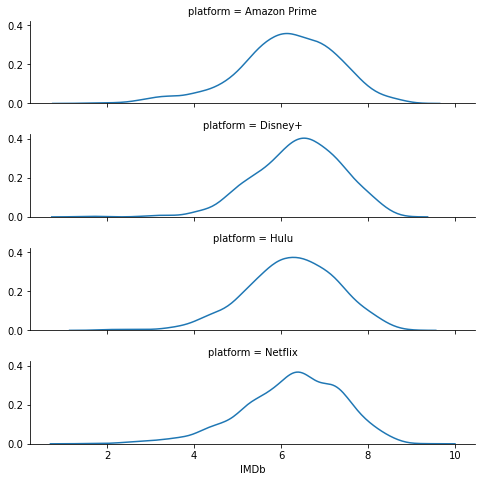

In [122]:
g = sns.FacetGrid(df_imdb_plot, row='platform', height=1.7, aspect=4,)
g.map(sns.kdeplot, 'IMDb')

<div class="alert alert-block alert-info">
<b>Comment:</b> Based on the data available, overall ratings on each platform are similarly distributed, peaking somewhere between 6 and 7. However, the majority of ratings data is focused on Netflix and hence may not be a good representation of the remaining platforms.
</div>

## Viz: Rating by Genre

In [123]:
genre_file='genre_cleaning.txt'
genre_dict = get_genre_dict(genre_file)

Chart 1/17: _Action & Adventure with 3848 titles


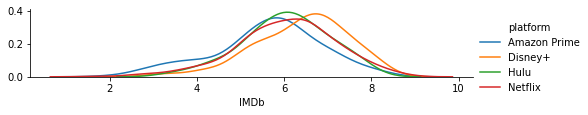

Chart 2/17: _Anime with 1760 titles


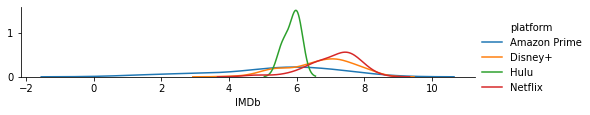

Chart 3/17: _Children & Family with 3444 titles


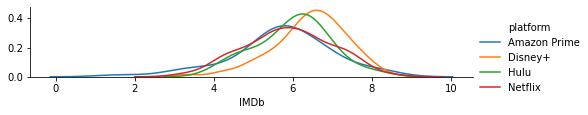

Chart 4/17: _Classics with 185 titles


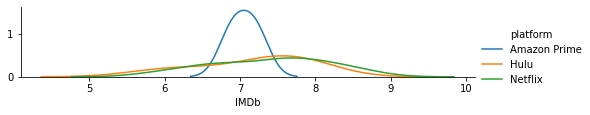

Chart 5/17: _Comedy with 5928 titles


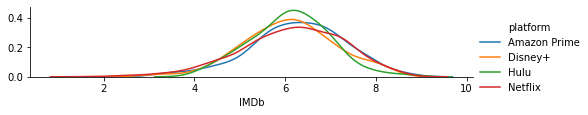

Chart 6/17: _Crime & Mystery with 859 titles


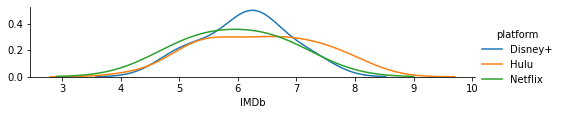

Chart 7/17: _Documentary with 3290 titles


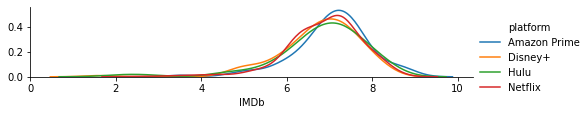

Chart 8/17: _Drama with 8181 titles


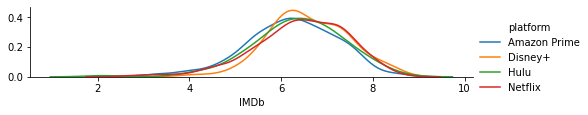

Chart 9/17: _Horror with 1621 titles


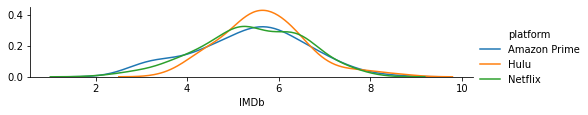

Chart 10/17: _Music with 704 titles


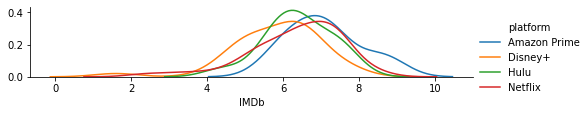

Chart 11/17: _Others with 4203 titles


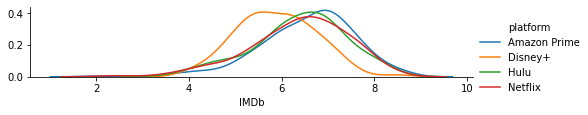

Chart 12/17: _Romance with 1867 titles


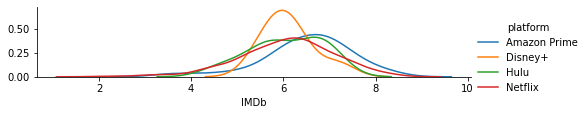

Chart 13/17: _Sci-Fi & Fantasy with 1242 titles


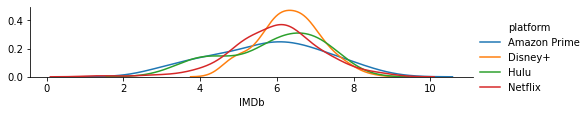

Chart 14/17: _Sports with 568 titles


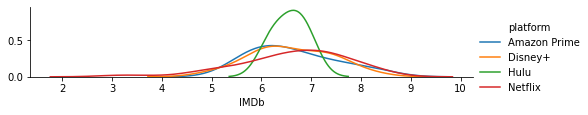

Chart 15/17: _Thrillers with 2373 titles


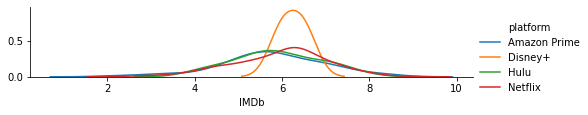

Chart 16/17: _Tv Shows with 1989 titles


C:\Users\aooi5\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


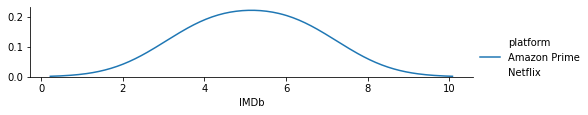

Chart 17/17: _International Movies with 2790 titles


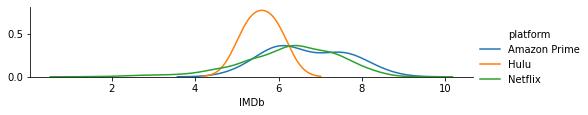

In [124]:
genre_column = list(map(lambda x: f"_{x}".title(), list(genre_dict.keys()) ))
num_row_by_genre_dict = df[genre_column].aggregate('sum', axis=0)
# print("Genre \t number of titles")
# print(num_row_by_genre_dict)

for t, g in enumerate(genre_column):

   dfg = df[df[g]==1]
   print(f"Chart {t+1}/{len(genre_column)}: {g} with {len(dfg)} titles")
   df_imdb_plot_g = dfg[['platform', 'IMDb']].dropna()
   g = sns.FacetGrid(df_imdb_plot_g, hue='platform', height=1.7, aspect=4)
   g.map(sns.kdeplot, 'IMDb')
   g.add_legend()
   plt.show()   
    

<div class="alert alert-block alert-info">
<b>Comment:</b> The KDE plot outlines the distribution of ratings for each genres on the platforms. While the available data is limited, especially for non-Netflix platforms, we can see that the ratings for each platforms are generally within similar bands for the genres, indicating that all these platforms offer a wide selection of shows across genres and are overall of similar quality.
</div>

## Analysis of time gap between show release year and date it was added to a platform
- Based on the analysis, we see that Netflix has the highest proportion of new movies. On the data available, more than 50% of Netflix's shows are added on its platform less than two years after it was released. This is followed by Amazon Prime, in which c. 40% of shows were added on its platform after it was released.
- Disney+ has distinctively more older shows on its platform. On the data available, where c. 50% of its titles has more than 10 years' gap between when it was released and listed on its platform. This could be due to the fact that Disney is a much older company has owns many classic titles which it then releases on its streaming platform.

In [125]:
# Find range between start and end date

"""
input : df, column_start_date, column_end_date, date_format = "%Y-%m-%d",
output : column name of the gap
added column: gap_{gap_type[0]}, gap_day
"""

def get_gap_between_dates(df,
                          column_date_start: str,
                          column_date_end: str,
                          format_start="%Y-%m-%d",
                          format_end="%Y-%m-%d",
                          gap_type="Year"):
    gap_col = f"gap_{gap_type}_"
    df["gap_day_"] = pd.to_datetime(df[column_date_end], format=format_start) - \
        pd.to_datetime(df[column_date_start], format=format_end)
    df[gap_col] = df["gap_day_"].astype(f"timedelta64[{gap_type[0].upper()}]").astype(int)
    return [gap_col, "gap_day_"]


"""
purpose: map single number into bin_range
inputs:
    input: single number to be mapped into bin_range
outputs:
    bin_range: [min(input_list), start_number_of_range1, start_number_of_range2, ..., max(input_list)]

added column 
"""

def binning(input, bin_range: list):
    input = np.array([input])
    bin_range = np.array(bin_range)
    index = np.argmin(((input - bin_range) >= 0).astype(int)) - 1
    bin = bin_range[index]
    return bin


def binning_columns(
    df, 
    bin_range: list,
    input_column="", 
    output_column_suffix="_bin",
    is_plot=True,
    title="",
    xlabel="",
    ylabel="Frequency",
):
    assert(len(input_column)), print("Please assign name of the column to be binned to input_column.")       
        
    if xlabel=="":
        xlabel=input_column
    
    suffix = output_column_suffix
    output_col = f"{input_column}{suffix}"
    df[output_col] = df[input_column].apply(lambda x: binning(x, bin_range))
    if is_plot:
        df[input_column].value_counts()[:20].sort_index().plot(
            kind="bar", title=title, xlabel=xlabel, ylabel=ylabel
            )
        plt.show()
        df[output_col].value_counts().sort_index().plot(
            kind="bar",  title = title, xlabel = f"{xlabel}_binned", ylabel = ylabel
            )
        plt.show()
    return output_col


In [126]:
df_date = comb_platform('platform_files.txt')
df_date = df_date[df_date.date_added.isna() == False]  #remove rows with empty date_added

gap_year, gap_day = get_gap_between_dates(df_date,
                                          column_date_start="release_year",
                                          format_start="%Y-%m-%d",
                                          column_date_end="date_added",
                                          format_end="%Y",
                                          gap_type="Year")

df_date = df_date[df_date[gap_year] >= 0]
bin_range = [df_date[gap_year].min(), 0, 1, 2, 5, 10, 20, df_date[gap_year].max() + 1]
output_col = binning_columns(df=df_date, input_column=gap_year, bin_range=bin_range, is_plot=False)

In [127]:
df_date.columns

Index(['platform', 'type', 'title', 'director', 'cast', 'country',
       'date_added', 'release_year', 'rating', 'duration', 'genre',
       'description', 'gap_day_', 'gap_Year_', 'gap_Year__bin'],
      dtype='object')

In [128]:
df_plt_gap = df_date[['platform', 'gap_Year__bin']]

In [129]:
df_plt_gap.notnull().sum()

platform         13424
gap_Year__bin    13424
dtype: int64

In [130]:
df_plt_gap['gap_Year__bin'] = df_plt_gap['gap_Year__bin'].astype('int')

C:\Users\aooi5\AppData\Local\Temp\ipykernel_19488\1399520701.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plt_gap['gap_Year__bin'] = df_plt_gap['gap_Year__bin'].astype('int')


In [131]:
cross_tab_gap_prop = pd.crosstab(index=df_plt_gap['platform'], columns=df_plt_gap['gap_Year__bin'], normalize='index')

In [132]:
cross_tab_gap = pd.crosstab(index=df_plt_gap['platform'], columns=df_plt_gap['gap_Year__bin'])

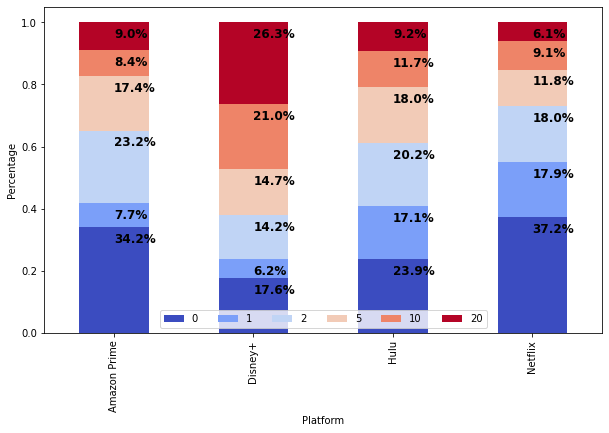

In [134]:
cross_tab_gap_prop.plot(kind='bar', stacked=True, colormap='coolwarm', figsize=(10,6))

plt.legend(loc='best', ncol=6)
plt.xlabel('Platform')
plt.ylabel('Percentage')

for n, a in enumerate([*cross_tab_gap.index.values]):
    gap = -0.05
    for proportion in cross_tab_gap_prop.loc[a]:            
        plt.text(x=n,
                 y=proportion + gap,
                 s=f'{np.round(proportion * 100, 1)}%', 
                 color="black",
                 fontsize=12,
                 fontweight="bold")
        gap += proportion

plt.show()

<div class="alert alert-block alert-info">
<b>Comment:</b>
    
    
- Based on the analysis, we see that Netflix has the highest proportion of new movies. On the data available, more than 50% of Netflix's shows are added on its platform less than two years after it was released. This is followed by Amazon Prime, in which c. 40% of shows were added on its platform after it was released.
    
    
    
- Disney+ has distinctively more older shows on its platform. On the data available, where c. 50% of its titles has more than 10 years' gap between when it was released and listed on its platform. This could be due to the fact that Disney is a much older company has owns many classic titles which it then releases on its streaming platform.
</div>

# Show Recommender

- In this section we build a show recommender to recommend similar shows and the plaforms they are on.


- This will be based on similar characteristics of a show in questions, including descriptions, genre, age-ratings, director, cast

In [135]:
# Generate dataframe for the recommender system:

pd.set_option('display.max_columns', None)

# 1. Create a basic dataframe from streaming platform data
df = comb_platform('platform_files.txt')


# 2. Unify features of shows (so that a show will have a unified director, cast, country, genre, and description)
df, df_dup = preproc_dup_df(df)

features_list = ['director', 'cast', 'country', 'genre', 'description']
filter_by = 'u_title'

for f in features_list:
    df = unify_feature(df, df_dup, filter_by, f)

# df = df.drop(['u_title'], axis=1)


# 3. Clean up rating and duration columns
df = correct_ratings_to_duration(df)
df = split_duration(df)


# 4. Group age ratings
age_bucket_file = 'rating_age_bucket.csv'
df = create_rating_age_bucket(df, age_bucket_file)


# 5. Group genre and create one-hot encoding of major genres
df = create_major_genres(df, col_header='genre', genre_file='genre_cleaning.txt', prefix_1hot='_')


## Content-Based Recommender Using Cosine Similarity

Background:

- Cosine similarity is a measure of similarity that can be used to compare documents irrespective of their size.


- A document can be represented by thousands of attributes, each recording the frequency of a particular word (e.g. a keyword) or phrase. In this way, a document can be represented as *term-frequency vector*.


- Term-frequency vectors are typically very long and sparse (they have many 0 values). Accordingly traditional distance measures like Euclidean distance do not work well for such vectors - two term-frequency vectors may have many 0 values in common, meaning that the corresponding documents do not share many words, but this does not make them similar.


- We need a measure for numeric data that ignores zero matches. Cosine similarity focuses on words that the two documents have in commons, and the occurence frequency of such words.


- Cosine similarity is defined as: 
$sim(x,y) = \frac{x \cdot y}{\lVert x \rVert \lVert y \rVert}$, where $x \cdot y$ is the dot product between the vectors $x$ and $y$, and $\lVert x \rVert$ is the Euclidean norm. This measures the conside of angle between vectors $x$ and $y$, and a value of 0 means that there is no match, and the close the value is to 1, the greater the match.



*References*:
- https://www.sciencedirect.com/topics/computer-science/cosine-similarity#:~:text=Cosine%20similarity%20measures%20the%20similarity,document%20similarity%20in%20text%20analysis.
- https://www.machinelearningplus.com/nlp/cosine-similarity/
- https://www.linkedin.com/pulse/count-vectorizers-vs-tfidf-natural-language-processing-sheel-saket/
- https://www.analyticsvidhya.com/blog/2020/02/quick-introduction-bag-of-words-bow-tf-idf/

## Different Vectorizers

A vectorizer converts a document into a frequency representation. We see two vectorizers in Python sklearn library: *countvectorizer* and *tfidvectorizer*

Count Vectorizer:
- Converts text into count frequency only
- Disadvantages include:
    - Its inability in identifying more important and less important words for analysis.
    - It will just consider words that are abundant in a corpus as the most statistically significant word.
    - It also doesn't identify the relationships between words such as linguistic similarity between words.


TF-IDF:
- TF-IDF: Term Frequency - Inverse Document Frequency. This is a statistic that is based on the frequency of a word in the corpus but it also provides a numerical representation of how important a word is for statistical analysis.
- TF-IDF is better than Count Vectorizers because it not only focuses on the frequency of words present in the corpus but also provides the importance of the words. We can then remove the words that are less important for analysis, hence making the model building less complex by reducing the input dimensions.
- TFIDF is based on the logic that words that are too abundant in a corpus and words that are too rare are both not statistically important for finding a pattern. Higher value of tfidf signifies higher importance of the words in the corpus while lower values represent lower importance.
- Main disadvantage is that it fails to provide linguistic information about the words such as the real meaning of the words


In [137]:
movie_df = df.copy()
movie_df['description'] = movie_df['description'].fillna('')

# create TF-IDF matrix based on description of the shows
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movie_df['description'])

# use linear_kernel to calculate consine similarities matrix between all the shows
# given that TF-IDF functionality produces normalized vectors, using linear_kernel yields the same result as 
# cosine_similarity, but is faster (saves the normalization operation)
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

# create indicies to label the consine similarity matrix
indices = pd.Series(movie_df.index, index=movie_df['title']).drop_duplicates()

tfidf_matrix.shape

(22998, 39942)

In [138]:
# function returns the top 5 show titles with the highese cosine similarties

def get_recommendations(title, cosine_sim=cosine_sim, indices=indices):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:6]
    movie_indices = [i[0] for i in sim_scores]
    movie_similarity = [i[1] for i in sim_scores]

    return pd.DataFrame(zip(movie_df['platform'].iloc[movie_indices], movie_df['title'].iloc[movie_indices], movie_similarity), columns=['platform', 'title', 'similarity'])

## Incorporating Additional Features (directors, cast, genre) to the System

In [110]:
# create data frame

features_df = ['platform', 'type', 'title', 'director', 'cast', 'country', 'targeted_age', 'genre', 'description']
movie_df = df[features_df].copy().fillna('')


# choose only the first director
movie_df['director'] = movie_df['director'].apply(lambda x : x.split(',')[0])


# choose the top 3 actors. We assume the actors are ordered by importance

n_cast = 3

movie_df['cast'] = movie_df['cast'].apply(lambda x: x.split(',') if len(x.split(',')) <=n_cast else x.split(',')[0:n_cast])
movie_df['cast'] = movie_df['cast'].apply(lambda x: ','.join(x))


# clean up features:
# (1) remove spaces for each element in the features and convert to small caps
# (2) add the feature name in front of each element in the feature so that it can be differentiated in the model

features = ['type', 'director', 'cast', 'country', "targeted_age", "genre"]

for feature in features:
    movie_df[feature] = movie_df[feature].apply(lambda x: str.lower(x.replace(" ", "")).replace(",", " "))
    movie_df[feature] = movie_df[feature].apply(lambda x: ' '.join([feature + '_' + itm for itm in x.split()]))


# create a text of consisting of the features we extracted, plus the show description

features_short = features

movie_df["join_features_short"] = movie_df.apply(lambda x: ' '.join(x[f] for f in features_short), axis=1)

features = features + ['description']

movie_df["join_features"] = movie_df.apply(lambda x: ' '.join(x[f] for f in features), axis=1)

In [111]:
# create TF-IDF matrix based on description of the shows
tfidf_join = TfidfVectorizer(stop_words='english')
tfidf_matrix_join = tfidf_join.fit_transform(movie_df['join_features'])

# use linear_kernel to calculate consine similarities matrix between all the shows
# given that TF-IDF functionality produces normalized vectors, using linear_kernel yields the same result as 
# cosine_similarity, but is faster (saves the normalization operation)
cosine_sim_join = linear_kernel(tfidf_matrix_join, tfidf_matrix_join)

# create indicies to label the consine similarity matrix
indices = pd.Series(movie_df.index, index=movie_df['title']).drop_duplicates()

### Result Comparison 1: "Pulp Fiction"

In [112]:
# recommender using description only:
print('Recommendation for "Pulp Ficton", using only show description:')
get_recommendations('Pulp Fiction')

Recommendation for "Pulp Ficton", using only show description:


,platform,title,similarity
0,Disney+,Muppets Most Wanted,0.227958
1,Hulu,Burger Scholar Sessions,0.188777
2,Amazon Prime,The Swindlers,0.174840
3,Amazon Prime,I Survived . . .,0.149505
4,Netflix,Blue Miracle,0.141357


In [113]:
# full join features
print('Recommendation for "Pulp Ficton", using only features AND description:')
get_recommendations('Pulp Fiction', cosine_sim=cosine_sim_join)

Recommendation for "Pulp Ficton", using only features AND description:


,platform,title,similarity
0,Netflix,Jackie Brown,0.183217
1,Netflix,Kill Bill: Vol. 2,0.170701
2,Netflix,Kill Bill: Vol. 1,0.170330
3,Netflix,The Hateful Eight,0.169449
4,Netflix,The Hateful Eight: Extended Version,0.166192


### Result Comparison 2: "Frozen"

In [114]:
# based on description only
print('Recommendation for "Frozen", using only show description:')
get_recommendations('Frozen')

Recommendation for "Frozen", using only show description:


,platform,title,similarity
0,Disney+,Frozen Fever,0.377775
1,Disney+,Olaf's Frozen Adventure,0.362644
2,Disney+,LEGO Disney Frozen: Northern Lights (Shorts),0.349825
3,Netflix,MONKART,0.232179
4,Disney+,Arendelle Castle Yule Log,0.223038


In [115]:
# full join features
print('Recommendation for "Frozen", using only features AND description:')
get_recommendations('Frozen', cosine_sim=cosine_sim_join)

Recommendation for "Frozen", using only features AND description:


,platform,title,similarity
0,Disney+,Frozen Fever,0.697877
1,Disney+,Frozen 2,0.483724
2,Disney+,Olaf's Frozen Adventure,0.399992
3,Disney+,LEGO Disney Frozen: Northern Lights (Shorts),0.282014
4,Disney+,Into the Unknown: Making Frozen 2,0.281863


<div class="alert alert-block alert-info">
<b>Comment:</b>

    
- We have created a recommender system for shows, which is based on analysing the information contained within the description, cast, director, genres of a show and finding other shows with high cosine similarities. We note unsuprisingly that incorporating additional information (e.g. cast, director, genre) can improve the accuracy of the recommender system. 

    
- Users can use the recommender to find platforms that have shows they prefer. For example, a user who likes shows like Pulp Fiction should gravitate towards Netflix, and shows like Frozen are featured more on Disney+.
    
</div>

# --- END ---